In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 이미지 로드
import pathlib
dataset_url = "/content/drive/MyDrive/car/sample100"
data_dir = pathlib.Path(dataset_url)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

400


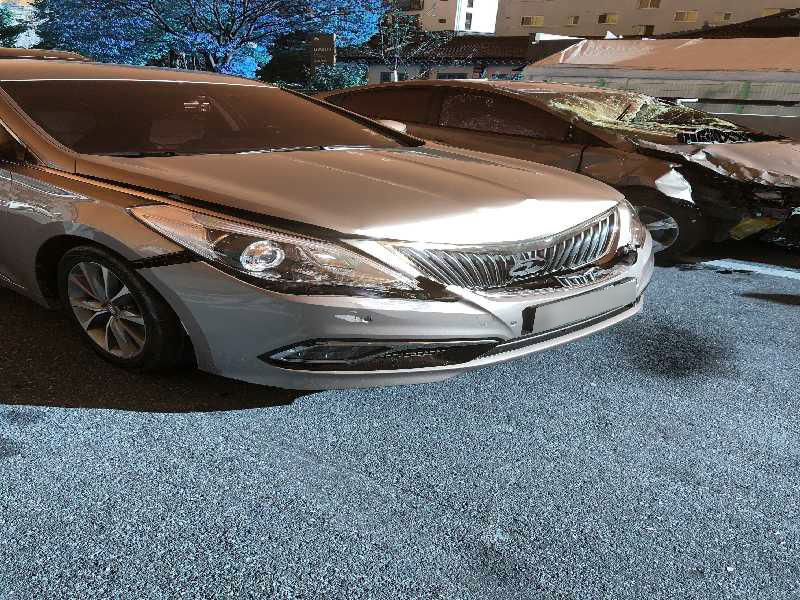

In [ ]:
# 이미지 확인
fbumperr = list(data_dir.glob('fbumperr/*'))
PIL.Image.open(str(fbumperr[0]))

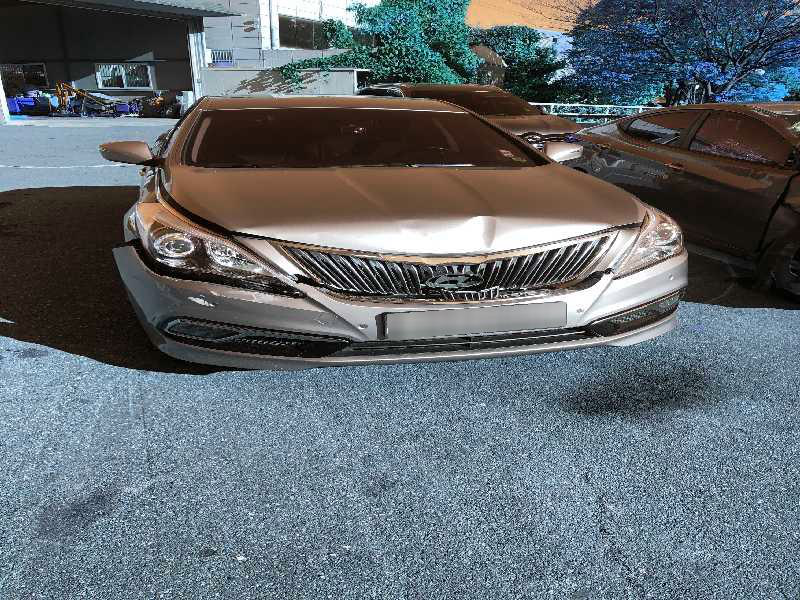

In [ ]:
PIL.Image.open(str(fbumperr[1]))

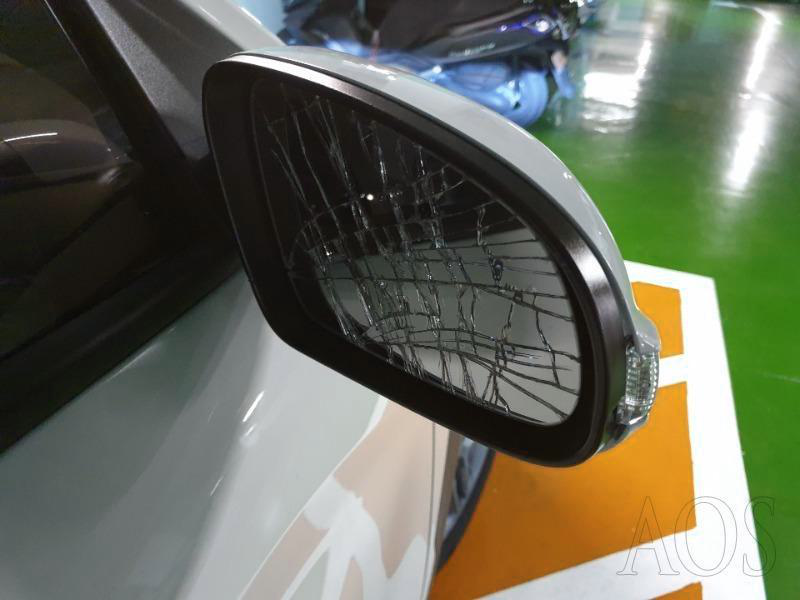

In [ ]:
side100 = list(data_dir.glob('side100/*'))
PIL.Image.open(str(side100[0]))

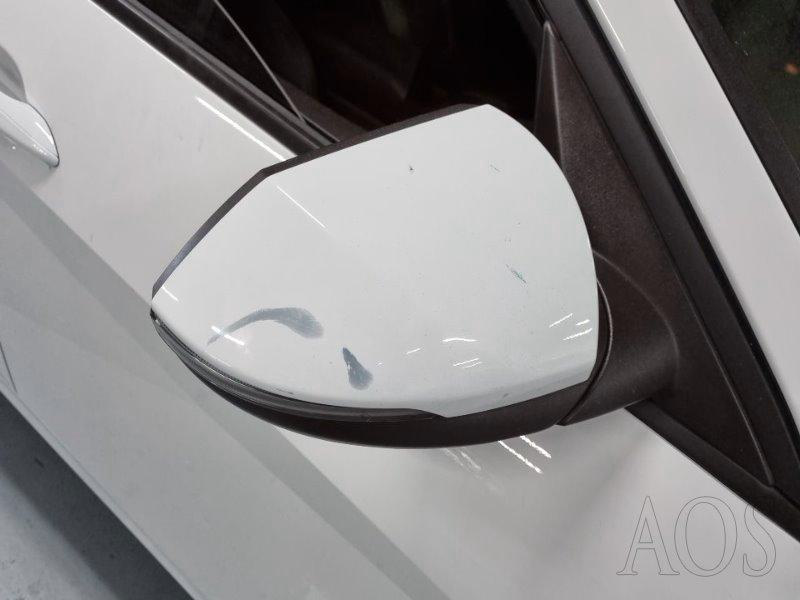

In [ ]:
PIL.Image.open(str(side100[1]))

In [ ]:
# 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# 데이터셋 분할
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 5 classes.
Using 320 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 5 classes.
Using 80 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['fbumperr', 'fbumpers', 'fronw100', 'side100', 'test']


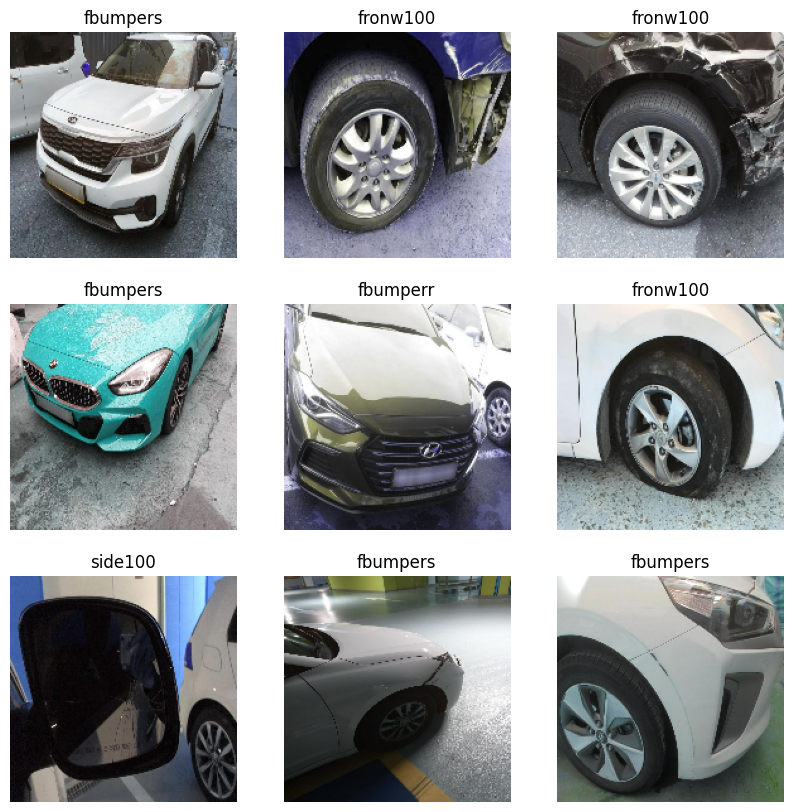

In [ ]:
# 훈련 데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 데이터 표준화
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# 모델 생성

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 24s 1s/step - loss: 1.4313 - accuracy: 0.3313 - val_loss: 1.3969 - val_accuracy: 0.3750
Epoch 2/10
10/10 [==============================] - 0s 30ms/step - loss: 1.0562 - accuracy: 0.6156 - val_loss: 0.9033 - val_accuracy: 0.5875
Epoch 3/10
10/10 [==============================] - 0s 24ms/step - loss: 0.6191 - accuracy: 0.7312 - val_loss: 0.8095 - val_accuracy: 0.6000
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 0.5236 - accuracy: 0.7719 - val_loss: 0.6111 - val_accuracy: 0.7250
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.2740 - accuracy: 0.9031 - val_loss: 0.6888 - val_accuracy: 0.6625
Epoch 6/10
10/10 [==============================] - 0s 23ms/step - loss: 0.1938 - accuracy: 0.9563 - val_loss: 0.8928 - val_accuracy: 0.6500
Epoch 7/10
10/10 [==============================] - 0s 24ms/step - loss: 0.1000 - accuracy: 0.9844 - val_loss: 0.8748 - val_accuracy: 0.7000
Epoch 8/10
10/

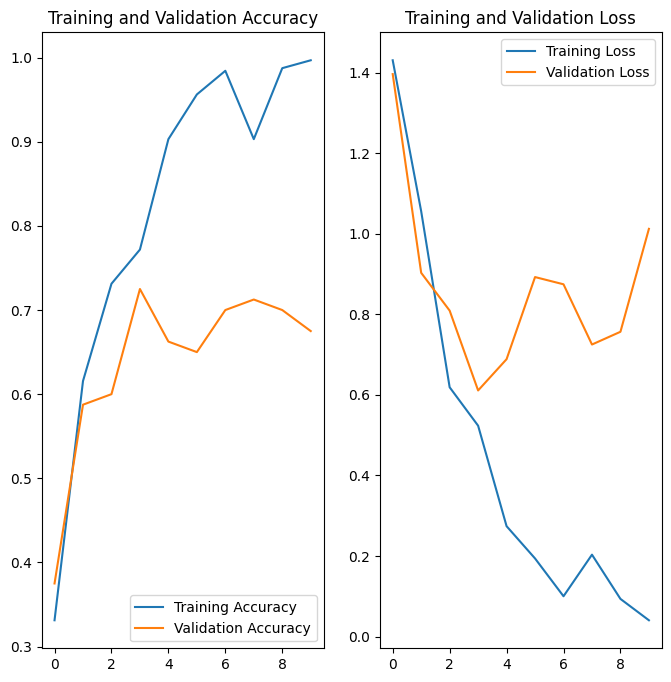

In [ ]:
# 모델 시각화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 데이터 증강

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

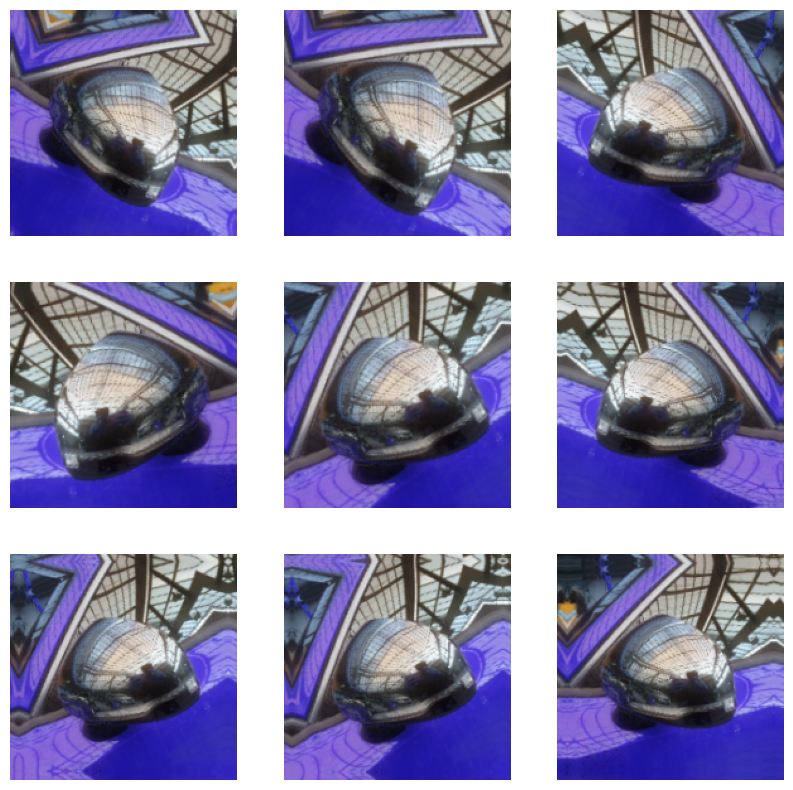

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Dropout 추가
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 4s 66ms/step - loss: 1.8898 - accuracy: 0.3156 - val_loss: 1.5069 - val_accuracy: 0.2250
Epoch 2/15
10/10 [==============================] - 0s 39ms/step - loss: 1.4349 - accuracy: 0.2781 - val_loss: 1.3188 - val_accuracy: 0.3250
Epoch 3/15
10/10 [==============================] - 0s 35ms/step - loss: 1.2667 - accuracy: 0.4375 - val_loss: 1.1404 - val_accuracy: 0.5000
Epoch 4/15
10/10 [==============================] - 0s 31ms/step - loss: 1.1534 - accuracy: 0.4875 - val_loss: 1.1179 - val_accuracy: 0.4000
Epoch 5/15
10/10 [==============================] - 0s 31ms/step - loss: 1.0394 - accuracy: 0.5375 - val_loss: 1.0433 - val_accuracy: 0.5375
Epoch 6/15
10/10 [==============================] - 0s 31ms/step - loss: 0.9722 - accuracy: 0.5875 - val_loss: 1.0261 - val_accuracy: 0.5000
Epoch 7/15
10/10 [==============================] - 0s 30ms/step - loss: 0.9136 - accuracy: 0.5781 - val_loss: 1.0096 - val_accuracy: 0.5125
Epoch 8/15
10

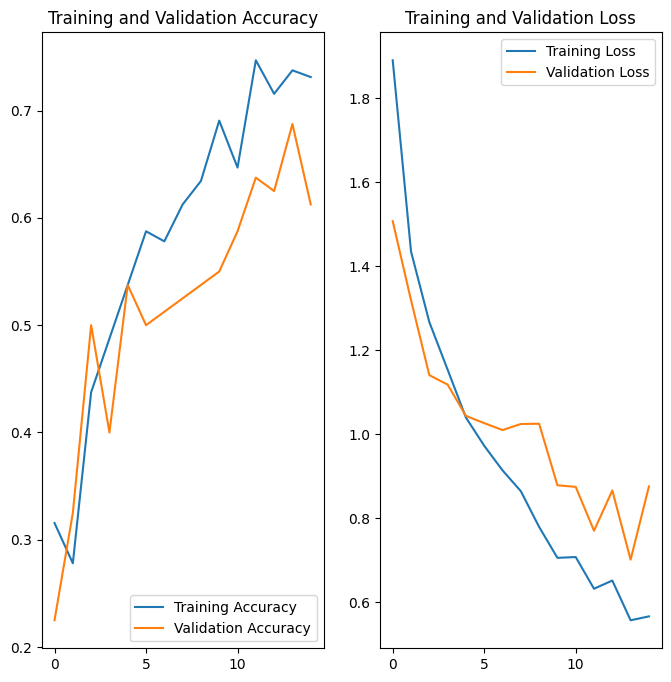

In [ ]:
# 훈련 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 새로운 데이터로 예측
car_url = "/content/drive/MyDrive/car/sample100/0632182_as-0041835.jpg"
img = tf.keras.utils.load_img(
    car_url, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 260ms/step
This image most likely belongs to fbumpers with a 89.45 percent confidence.
